# Training Neural Networks

The network we built in Part 1 is dumb, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="https://drive.google.com/uc?id=1RgTsNL493xOyoGAEm72XNv39LflYMguN" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
C = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='https://drive.google.com/uc?id=1Z3PpvEXeDBDHrylvTstoqKsqG6557VQV' width=350px>

## Backpropagation

For single layer networks, gradient descent is simple to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks, although it's straightforward once you learn about it. 

This is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src="https://drive.google.com/uc?id=1S7zeIG1PDOFutyYCd-j-7zDJc-ONxlvv" width=400px>



In the forward pass through the network, our data and operations go from right to left here. To train the weights with gradient descent, we propagate the gradient of the cost backwards through the network. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\frac{\partial C}{\partial w_1} = \frac{\partial l_1}{\partial w_1} \frac{\partial s}{\partial l_1} \frac{\partial l_2}{\partial s} \frac{\partial C}{\partial l_2}
$$

We update our weights using this gradient with some learning rate $\alpha$. 

$$
w^\prime = w - \alpha \frac{\partial C}{\partial w}
$$

The learning rate is set such that the weight update steps are small enough that the iterative method settles in a minimum.

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

Virat## Gradients

In PyTorch, the gradients are calculated automatically. It does this by keeping track of operations performed on tensors. For PyTorch to track operations and calculate the gradients, you need to set `require_grad` = `True` when creating a tensor.

The gradients of a tensor (e.g.,`z`) are computed with respect to the variable that created it using `z.backward()`. This does a backward pass through the operations that created `z`.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
x = torch.ones(2,2,requires_grad=True)
x

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

In [3]:
y = 3*(x+1)**2
y

tensor([[12., 12.],
        [12., 12.]], grad_fn=<MulBackward0>)

Below we can see the operation that created `y`, a `MulConstant` op.

In [4]:
## grad_fn shows the function that generated this variable
y.grad_fn

In [5]:
z = y.mean()
z

tensor(12., grad_fn=<MeanBackward0>)

Again, we can check out how `z` was created, with a `Mean` operation.

In [6]:
z.grad_fn

Since we haven't performed a backward pass, `x` doesn't have a gradient yet.

In [7]:
x.grad

Now we can calculate the gradients of `z` with respect to `x` with `z.backward()`.

In [8]:
z.backward()
x.grad

tensor([[3., 3.],
        [3., 3.]])

These gradients calculations are particularly useful for neural networks. For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the cost, then, go backwards to calculate the gradients with respect to the cost. Once we have the gradients we can make a gradient descent step. 

## Training the network!

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

In [9]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [10]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 200, 50, 10 units each
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 50)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(50, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x
    
    def predict(self, x):
        ''' This function for predicts classes by calculating the softmax '''
        logits = self.forward(x)
        return F.softmax(logits)

In [11]:
net = Network()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

First, let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes.

In [12]:
print('Initial weights - ', net.fc1.weight)

dataiter = iter(trainloader)
inputs, targets = next(dataiter)

inputs.resize_(64, 784)

# Clear the gradients from all Tensors
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = net.forward(inputs)
loss = criterion(output, targets)
loss.backward()
print('Gradient -', net.fc1.weight.grad)
optimizer.step()

Initial weights -  Parameter containing:
tensor([[ 0.0317,  0.0156, -0.0238,  ..., -0.0324,  0.0312,  0.0234],
        [ 0.0055, -0.0013,  0.0041,  ...,  0.0339,  0.0035,  0.0289],
        [-0.0249, -0.0252, -0.0025,  ...,  0.0134,  0.0034, -0.0068],
        ...,
        [-0.0091, -0.0137, -0.0128,  ...,  0.0158, -0.0040, -0.0069],
        [ 0.0129,  0.0037,  0.0100,  ...,  0.0242,  0.0317,  0.0002],
        [ 0.0313,  0.0159,  0.0248,  ...,  0.0060,  0.0062,  0.0082]],
       requires_grad=True)
Gradient - tensor([[-1.5852e-03, -1.5852e-03, -1.5852e-03,  ..., -1.5852e-03,
         -1.5852e-03, -1.5852e-03],
        [ 1.7221e-03,  1.7221e-03,  1.7221e-03,  ...,  1.7221e-03,
          1.7221e-03,  1.7221e-03],
        [-5.2973e-03, -5.2973e-03, -5.2973e-03,  ..., -5.2973e-03,
         -5.2973e-03, -5.2973e-03],
        ...,
        [ 1.8418e-03,  1.8418e-03,  1.8418e-03,  ...,  1.8418e-03,
          1.8418e-03,  1.8418e-03],
        [-7.2401e-05, -7.2401e-05, -7.2401e-05,  ..., -7.2401e

We will output the updated weights that are updated using SGD with learning rate (0.01). Since both the learning rate and gradients are small, the changes of the weights might not be drastic

In [13]:
print('Updated weights - ', net.fc1.weight)

Updated weights -  Parameter containing:
tensor([[ 0.0317,  0.0156, -0.0238,  ..., -0.0324,  0.0312,  0.0234],
        [ 0.0055, -0.0013,  0.0040,  ...,  0.0339,  0.0035,  0.0289],
        [-0.0248, -0.0251, -0.0025,  ...,  0.0135,  0.0035, -0.0067],
        ...,
        [-0.0091, -0.0137, -0.0128,  ...,  0.0158, -0.0040, -0.0069],
        [ 0.0129,  0.0037,  0.0100,  ...,  0.0242,  0.0317,  0.0002],
        [ 0.0313,  0.0159,  0.0249,  ...,  0.0060,  0.0062,  0.0082]],
       requires_grad=True)


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. This is fairly straightforward. We'll loop through the mini-batches in our dataset, pass the data through the network to calculate the losses, get the gradients, then run the optimizer

In [14]:
net = Network()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [15]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
for e in range(epochs):
    for inputs, targets in iter(trainloader):
        steps += 1
        # Flatten MNIST images into a 784 long vector
        inputs.resize_(inputs.size()[0], 784)

        optimizer.zero_grad()
        
        output = net(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Test accuracy
            accuracy = 0
            for ii, (inputs, targets) in enumerate(testloader):
                
                inputs = inputs.resize_(inputs.size()[0], 784)
                
                predicted = net.predict(inputs).data
                equality = (targets == predicted.max(1)[1])
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Test accuracy: {:.4f}".format(accuracy/(ii+1)))
            running_loss = 0

/tmp/ipykernel_12611/2427501245.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(logits)


Epoch: 1/1 Loss: 2.1682 Test accuracy: 0.4681
Epoch: 1/1 Loss: 1.7568 Test accuracy: 0.6012
Epoch: 1/1 Loss: 1.2875 Test accuracy: 0.6911
Epoch: 1/1 Loss: 1.0045 Test accuracy: 0.7075
Epoch: 1/1 Loss: 0.8660 Test accuracy: 0.7825
Epoch: 1/1 Loss: 0.7529 Test accuracy: 0.7801
Epoch: 1/1 Loss: 0.7209 Test accuracy: 0.7986
Epoch: 1/1 Loss: 0.6259 Test accuracy: 0.8306
Epoch: 1/1 Loss: 0.5708 Test accuracy: 0.8510
Epoch: 1/1 Loss: 0.5588 Test accuracy: 0.8589
Epoch: 1/1 Loss: 0.5258 Test accuracy: 0.8712
Epoch: 1/1 Loss: 0.4699 Test accuracy: 0.8663
Epoch: 1/1 Loss: 0.4156 Test accuracy: 0.8671
Epoch: 1/1 Loss: 0.4082 Test accuracy: 0.8756
Epoch: 1/1 Loss: 0.4711 Test accuracy: 0.8523
Epoch: 1/1 Loss: 0.4835 Test accuracy: 0.8669
Epoch: 1/1 Loss: 0.4422 Test accuracy: 0.8655
Epoch: 1/1 Loss: 0.4190 Test accuracy: 0.8805
Epoch: 1/1 Loss: 0.4222 Test accuracy: 0.8813
Epoch: 1/1 Loss: 0.4497 Test accuracy: 0.8864
Epoch: 1/1 Loss: 0.3909 Test accuracy: 0.8975
Epoch: 1/1 Loss: 0.3545 Test accur

In [16]:
dataiter = iter(testloader)
inputs, targets = next(dataiter)

For a better visualization, we define the following function

In [17]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,7), ncols=2)
    ax1.imshow(img.numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10).astype(int), size='large');
    ax2.set_title('Digit Probability')
    ax2.set_xlim(0, 1.1)

/tmp/ipykernel_12611/2427501245.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(logits)


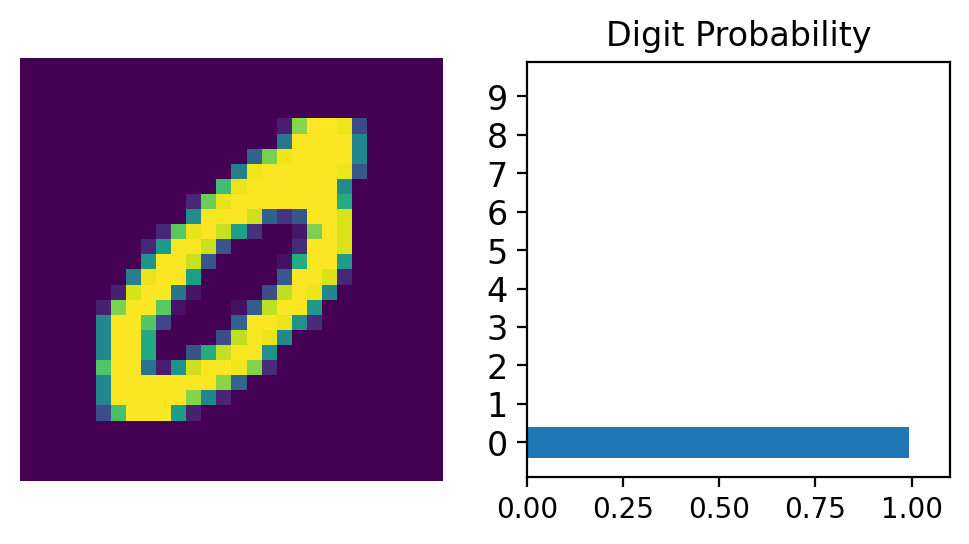

In [18]:
img = inputs[0]
ps = net.predict(img.resize_(1, 784))
view_classify(img.resize_(1, 28, 28), ps)